## PYTHON PACKAGES

In [90]:
'''
    This module contains all functions relating to the cleaning, exploration and feature engineering of structured data sets; 
    mostly in pandas format


    install the anaconda python distribution to be able to use numpy, pandas, matplotlib, seaborn, scipy, sklearn and datetime

    use pip install category_encoders for category_encoders 
    use pip install category_embedder for category_embedder. It requires the tensorflow and keras.
    use pip install xgboost
    use pip install mlxtend
    
'''

##pip install category_encoders

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import category_embedder as ce
from category_encoders import *
from IPython.display import display
from collections import Counter
import scipy.stats as sp
from scipy.stats import zscore
from scipy import stats
import datetime as dt
import re
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error,accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from mlxtend.evaluate import combined_ftest_5x2cv, mcnemar_table, mcnemar, paired_ttest_5x2cv, cochrans_q
#print(tf.__version__)
le = LabelEncoder()
import warnings
warnings.simplefilter('ignore')

## EXPLORATORY AND STATISTICAL ANALYSIS

In [4]:
def get_cat_feats(data=None):
    '''
    Returns the categorical features in a data set
    Parameters:
    -----------
        data: DataFrame or named Series 
    Returns:
    -------
        List
            A list of all the categorical features in a dataset.
    it is used as a helper function for most of the functions to get categorical variables
    '''
    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    cat_features = data.select_dtypes(include=['object']).columns

    return list(cat_features)

In [5]:
def get_num_feats(data=None):
    '''
    Returns the numerical features in a data set
    Parameters:
    -----------
        data: DataFrame or named Series 
    Returns:
    -------
        List:
            A list of all the numerical features in a dataset.
    it is used as a helper function for most of the functions to get categorical variables
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    num_features = data.select_dtypes(include=numerics).columns

    return list(num_features)

In [6]:
def get_unique_counts(data=None):
    '''
    Gets the unique count of categorical features in a data set.
    Parameters
    -----------
        data: DataFrame or named Series 
    Returns
    -------
        DataFrame or Series
            Unique value counts of the features in a dataset.
    it is used as a helper function in the describe function to get the count of unique values in the columns 
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    features = get_cat_feats(data)
    temp_len = []

    for feature in features:
        temp_len.append(len(data[feature].unique()))
        
    df = list(zip(features, temp_len))
    df = pd.DataFrame(df, columns=['Feature', 'Unique Count'])
    df = df.style.bar(subset=['Unique Count'], align='mid')
    return df

In [7]:
def display_missing(data=None, plot=False):
    '''
    Display missing values as a pandas dataframe.
    Parameters
    ----------
        data: DataFrame or named Series
        plot: bool, Default False
            Plots missing values in dataset as a heatmap
    
    Returns
    -------
        Matplotlib Figure:
            Heatmap plot of missing values
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    df = data.isna().sum()
    df = df.reset_index()
    df.columns = ['features', 'missing_counts']

    missing_percent = round((df['missing_counts'] / data.shape[0]) * 100, 1)
    df['missing_percent'] = missing_percent

    if plot:
        plot_missing(data)
        return df
    else:
        return df

In [8]:
def cat_summarizer(data, x=None, y=None, hue=None, palette='Set1', verbose=True):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Parameters:
    ---------------------------
        dataframe: pandas dataframe
        x: str.
            horizontal axis to plot the labels of categorical data, y would be the count.
        y: str. 
            vertical axis to plot the labels of categorical data, x would be the count.
        hue: str. i
            if you want to compare it another variable (usually the target variable)
        palette: array, list.
            Colour of the plot
    Returns:
    ----------------------
        Quick Stats of the data and also the count plot
        
        it is used in the describe function
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = data[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=data, palette=palette)
    plt.show()

In [9]:
def _space():
    '''it is used in  most functions to add space. this makes result more presentation'''
    print('\n')
def _match_date(data):
    '''
        Return a list of columns that matches the DateTime expression
    '''
    mask = data.sample(20).astype(str).apply(lambda x : x.str.match(r'(\d{2,4}-\d{2}-\d{2,4})+').all())
    return set(data.loc[:, mask].columns)


def display_rows(data,num=2):
    '''
    Displays the required number of rows
    it is used in the describe function
    '''
    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")

    return data.head(num)

In [10]:
def plot_missing(data=None):
    '''
    Plots the data as a heatmap to show missing values
    Parameters
    ----------
        data: DataFrame, array, or list of arrays.
            The data to plot.
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    sns.heatmap(data.isnull(), cbar=True)
    plt.show()

In [11]:
def class_count(data=None, features=None, plot=False, save_fig=False):
    '''df, method='up_sample_minority_class',target,majority_class= 0,minority_class= 1,number_of_samples= 3000
    Displays the number of classes in a categorical feature.
    Parameters:
    
        data: Pandas DataFrame or Series
            Dataset for plotting.
        features: Scalar, array, or list. 
            The categorical features in the dataset, if None, 
            we try to infer the categorical columns from the dataframe.
        plot: bool, Default False.
            Plots the class counts as a barplot
        save_fig: bool, Default False.
            Saves the plot to the current working directory.
    it is used in the describe function
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    if features is None:
        features = get_cat_feats(data)

                        

    for feature in features:
        if data[feature].nunique() > 15:
            print("Unique classes in {} too large".format(feature))
        else:
            print('Class Count for', feature)
            display(pd.DataFrame(data[feature].value_counts()))

    if plot:
        countplot(data, features, save_fig=save_fig)

In [12]:
def get_date_cols(data=None):
    '''
    Returns the Datetime columns in a data set.
    Parameters
    ----------
        data: DataFrame or named Series
            Data set to infer datetime columns from.
        convert: bool, Default True
            Converts the inferred date columns to pandas DateTime type
    Returns:
    -------
        List
         Date column names in the data set
    use in the describe function to set date columns to datetime datatype in utc
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    #Get existing date columns in pandas Datetime64 format
    date_cols = set(data.dtypes[data.dtypes == 'datetime64[ns, UTC]'].index)
    #infer Date columns 
    date_cols = date_cols.union(_match_date(data))
       
    return date_cols

In [13]:
def bivariate_stats(data):
    '''Returns the contingency table and chi2 contingency test result between columns in the dataframe
        
        it is used in the describe function for categorical features analysis 
    
    
    '''
    cat_feats = get_cat_feats(data=data)
    counter = 1
    try:
        while counter<(len(cat_feats)):
            val1 = get_cat_feats(data=datainput)[counter - 1]
            val2 = get_cat_feats(data=datainput)[counter]
            if (data[val1].nunique() > 15) or (data[val2].nunique() > 15):
                print('Number of unique values too large')
            else:
                freqtab = pd.crosstab(data[val1], data[val2])
                print("Frequency table")
                print("============================")
                print(freqtab)
                print("============================")
                chi2, pval, dof, expected = sp.chi2_contingency(freqtab)
                print("ChiSquare test statistic: ",chi2)
                print("p-value: ",pval)
                _space()
            counter= counter+1
    except:
        pass

In [14]:
def bivariate_stats_target(data, target):
    
    '''Returns the contingency table and chi2 contingency test result between columns and the target variable in the dataframe
        
        
        Parameters
    ----------
        data: DataFrame or named Series
            Data set to infer datetime columns from.
        target: the target variable in form of string

        
        it is used in the describe function for categorical features analysis of the relationship between the target variable 
        and other categorical features
    
    
    '''
    cat_feats = get_cat_feats(data=data)
    for i in cat_feats:
        if (data[i].nunique() > 20):
            print('Number of Unique values too large')
        else:
            freqtab = pd.crosstab(data[i], data[target])
            print("Frequency table")
            print("============================")
            print(freqtab)
            print("============================")
            chi2, pval, dof, expected = sp.chi2_contingency(freqtab)
            print("ChiSquare test statistic: ",chi2)
            print("p-value: ",pval)
            _space()

### Visuals

In [15]:
def heatmap(data):
    '''
    shows heatmap of missing values

    '''
    sns.heatmap(data.isnull(), cbar=False)

In [16]:
def count_check(data):
    ''' 
    unique count check

    '''
    feats = [f for f in data.columns]
    for i in feats:
        print ('==' + str(i) + '==')
        print ('data:' + str(data[i].nunique()/data.shape[0]))


In [17]:
def mean_std(data):
    # Distribution of mean and std
    feats  = [f for f in data.columns ]
    plt.figure(figsize=(16,6))
    features = data[feats].columns.values
    plt.title("Distribution of mean values per row in the data")
    sns.distplot(data[features].mean(axis=1),color="green", kde=True,bins=120, label='data')
    plt.legend()
    plt.show()

In [18]:
def  cat_plot(data):
    '''plot multiple categorical features as bar charts on the same plot

    '''
    feats  = [f for f in data.columns ]
    categorical_features = data.select_dtypes(exclude=["number","bool_"]).columns
    fig, ax = plt.subplots(1, len(categorical_features))
    for i, categorical_feature in enumerate(data[categorical_features]):
        data[categorical_feature].value_counts().plot(kind ="bar", ax=ax[i]).set_title(categorical_feature)
    fig.show()

In [19]:
def corr(data):
    '''Feature Correlation

    '''
    feats  = [f for f in data.columns ]
    correlations = data[feats].corr().unstack().sort_values(kind="quicksort").reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']]
    correlations

In [20]:
def pairplot(data):
    '''
    pairplot on datasets
    '''
    sns.set(style="ticks", color_codes=True)
    g = sns.pairplot(data)

## Feature Processing; Missing Value Imputation, Date Feature Extraction, Categorical Feature Encoding, Outlier Removal, Data Scaling and Normalization, and Data Sampling for Imbalance Dataset

In [21]:
def date_processing(data=None, date_cols = None, utc=True):
    '''
    This function is used for preprocessing date columns and creating new columns from the date columns.
    
    It is used in the feature_processing function.
    
    
    '''
    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")
        
    for i in date_cols:
        data[i] = pd.to_datetime(data[i], utc=utc)
        data[f'month_{i}'] = data[i].dt.month
        data[f'year_{i}'] = data[i].dt.year
        data[f'day_{i}'] = data[i].dt.day
        data[f'dayweek_{i}'] = data[i].dt.weekday
        #data = data.drop(date_cols, axis=1)
    return data

In [22]:
date_processing(data=data, date_cols = ['Date'])

,ID,Date,Temperature,Humidity,Operator,Measure1,Measure2,Measure3,Measure4,Measure5,...,?Date.month,?Date.day-of-month,?Date.day-of-week,?Date.hour,?Date.minute,?Date.second,month_Date,year_Date,day_Date,dayweek_Date
0,1,2016-01-01 00:00:00+00:00,67,82,Operator1,291,1,1,1041,846,...,1,1,5,0,0,0,1,2016,1,4
1,2,2016-01-01 01:00:00+00:00,68,77,Operator1,1180,1,1,1915,1194,...,1,1,5,1,0,0,1,2016,1,4
2,3,2016-01-01 02:00:00+00:00,64,76,Operator1,1406,1,1,511,1577,...,1,1,5,2,0,0,1,2016,1,4
3,4,2016-01-01 03:00:00+00:00,63,80,Operator1,550,1,1,1754,1834,...,1,1,5,3,0,0,1,2016,1,4
4,5,2016-01-01 04:00:00+00:00,65,81,Operator1,1928,1,2,1326,1082,...,1,1,5,4,0,0,1,2016,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,7901,2016-11-25 04:00:00+00:00,60,81,Operator7,1637,3,0,1950,1923,...,11,25,5,4,0,0,11,2016,25,4
7901,7902,2016-11-25 05:00:00+00:00,63,81,Operator7,1719,3,2,508,1748,...,11,25,5,5,0,0,11,2016,25,4
7902,7903,2016-11-25 06:00:00+00:00,60,83,Operator7,1511,2,1,1318,1871,...,11,25,5,6,0,0,11,2016,25,4
7903,7904,2016-11-25 07:00:00+00:00,63,80,Operator7,1325,3,1,1371,1355,...,11,25,5,7,0,0,11,2016,25,4


In [23]:
def drop_missing(data=None, percent=99):
    '''
    Drops missing columns with [percent] of missing data.
    Parameters:
    -------------------------
        data: Pandas DataFrame or Series.
        percent: float, Default 99
            Percentage of missing values to be in a column before it is eligible for removal.
    Returns:
    ------------------
        Pandas DataFrame or Series.
    It can be used alone. It also used in deal_with_missing_value function.
    
    This function is used in the deal_with_missing_value function.
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")
    
    missing_percent = (data.isna().sum() / data.shape[0]) * 100
    cols_2_drop = missing_percent[missing_percent.values >= percent].index
    print("Dropped {}".format(list(cols_2_drop)))
    #Drop missing values
    df = data.drop(cols_2_drop, axis=1)
    return df

def fill_missing_cats(data=None, cat_features=None, missing_encoding=None, missing_col=False):
    '''
    Fill missing values using the mode of the categorical features.
    Parameters:
    ------------------------
        data: DataFrame or name Series.
            Data set to perform operation on.
        cat_features: List, Series, Array.
            categorical features to perform operation on. If not provided, we automatically infer the categoricals from the dataset.
        missing_encoding: List, Series, Array.
            Values used in place of missing. Popular formats are [-1, -999, -99, '', ' ']
        missin_col: bool, Default True
      Creates a new column to capture the missing values. 1 if missing and 0 otherwise. This can sometimes help a machine learning model.
      
      This function is used in the deal_with_missing_value function.
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")

    if cat_features is None:
        cat_features = get_cat_feats(data)

    df = data.copy()
    #change all possible missing values to NaN
    if missing_encoding is None:
        missing_encoding = ['', ' ', -99, -999]

    df.replace(missing_encoding, np.NaN, inplace=True)
    
    for feat in cat_features:
        if missing_col:
            df[feat + '_missing_value'] = (df[feat].isna()).astype('int64')
        most_freq = df[feat].mode()[0]
        df[feat] = df[feat].replace(np.NaN, most_freq)
            
    return df

def fill_missing_num(data=None, num_features=None, method='mean', missing_col=False):
    '''
    fill missing values in numerical columns with specified [method] value
    Parameters:
        ------------------------------
        data: DataFrame or name Series.
            The data set to fill
        features: list.
            List of columns to fill
        method: str, Default 'mean'.
            method to use in calculating fill value.
        missing_col: bool, Default True
          Creates a new column to capture the missing values. 1 if missing and 0 otherwise. This can sometimes help a machine learning model.
          
          This function is used in the deal_with_missing_value function.
    '''
    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")
    
    if num_features is None:
        num_features = get_num_feats(data)
        #get numerical features with missing values
        temp_df = data[num_features].isna().sum()
        features = list(temp_df[num_features][temp_df[num_features] > 0].index)
        
    df = data.copy()
    for feat in features:
        if missing_col:
            df[feat + '_missing_value'] = (df[feat].isna()).astype('int64')
        if method is 'mean':
            mean = df[feat].mean()
            df[feat].fillna(mean, inplace=True)
        elif method is 'median':
            median = df[feat].median()
            df[feat].fillna(median, inplace=True)
        elif method is 'mode':
            mode = df[feat].mode()[0]
            df[feat].fillna(mode, inplace=True)
        else:
            raise ValueError("method: must specify a fill method, one of [mean, mode or median]'")
    return df

In [24]:
def deal_with_missing_value(data, percent=70):
    """
    this function automatically take care of missing values.
        It fills the missing values in categorical variables with mode of the particular column
        and fills the missing value numerical variables with mean of the particular column.
        It automatically drops columns with more than 70% missing values except when set otherwise.
        
        This function is used in the feature_preprocessing function to deal with missing values. It can also be used alone.
        """
    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")
    df1 = drop_missing(data=data, percent=percent)
    df2 = fill_missing_cats(data=df1)
    df = fill_missing_num(data=df2)
    return df

In [25]:
def drop_redundant(data):
    '''
    Removes features with the same value in all cell. Drops feature If Nan is the second unique class as well.
    Parameters:
    -----------------------------
        data: DataFrame or named series.
    
    Returns:
        DataFrame or named series.
    This function is used in the feature_processing function.
    '''

    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")
    
    #get columns
    cols_2_drop = _nan_in_class(data)
    print("Dropped {}".format(cols_2_drop))
    df = data.drop(cols_2_drop, axis=1)
    return df
def _nan_in_class(data):
    """helper function for drop_redundant function"""
    cols = []
    for col in data.columns:
        if len(data[col].unique()) == 1:
            cols.append(col)

        if len(data[col].unique()) == 2:
            if np.nan in list(data[col].unique()):
                cols.append(col)

    return cols
def get_qcut(data=None, col=None, q=None, duplicates='drop', return_type='float64'):
    '''
    Cuts a series into bins using the pandas qcut function
    and returns the resulting bins as a series for merging.
    Parameter:
    -------------
        data: DataFrame, named Series
            Data set to perform operation on.
        col: str
            column to cut/binnarize.
        q: integer or array of quantiles
            Number of quantiles. 10 for deciles, 4 for quartiles, etc. Alternately array of quantiles, e.g. [0, .25, .5, .75, 1.] for quartiles.
        duplicates: Default 'drop',
            If bin edges are not unique drop non-uniques.
        return_type: dtype, Default (float64)
            Dtype of series to return. One of [float64, str, int64]
    
    Returns:
    --------
        Series, 1D-Array
        
        This function is not used in any other function. It can be used alone.
    '''

    temp_df = pd.qcut(data[col], q=q, duplicates=duplicates).to_frame().astype('str')
    #retrieve only the qcut categories
    df = temp_df[col].str.split(',').apply(lambda x: x[0][1:]).astype(return_type)
    
    return df

In [27]:
d = deal_with_missing_value(data, percent=70)

Dropped []


In [28]:
d.isnull().sum()

ID                              0
Date                            0
Temperature                     0
Humidity                        0
Operator                        0
Measure1                        0
Measure2                        0
Measure3                        0
Measure4                        0
Measure5                        0
Measure6                        0
Measure7                        0
Measure8                        0
Measure9                        0
Measure10                       0
Measure11                       0
Measure12                       0
Measure13                       0
Measure14                       0
Measure15                       0
Hours Since Previous Failure    0
Failure                         0
?Date.year                      0
?Date.month                     0
?Date.day-of-month              0
?Date.day-of-week               0
?Date.hour                      0
?Date.minute                    0
?Date.second                    0
month_Date    

### Encoding Techniques

In [30]:
#Label Encoding for object to numeric conversion
def binaryencoder(data):
    """To avoid the curse of dimensionality, this function only encodes categorical features with less than 7 unique values
    
        This function can be used alone. It is also used in the encode_data function.
        
        It is the default method for encoding categorical variables with unique value less than four in the encode_data function.
        
        explanation: It is similar to onehot encoding but gives lesser dimensions, making it a better option. 
                    It converts the unique entry into binary combination and then creates column using binary hashing.
    """
    features = get_cat_feats(data=data)
    cols = []
    for feature in features:
        if data[feature].nunique() < 7:
            cols.append(feature)
        
    enc = BinaryEncoder(cols=cols).fit(data)
    data = enc.transform(data)
    return data

def onehotencoder(data):
    """To avoid the curse of dimensionality, this function only encodes categorical features with less than 4 unique values
    
        This function can be used alone. It is also used in the encode_data function
        
    The onehotencoder is only used when the number of unique value is less than four to avoid the curse of dimensionality.
    If encode_data method parameter is set to 'onehotencode' this is what is used in encoding categorical variables with 
    number of unique values less than 4.
    
    explanation: it is used mostly for nominal variables such that a binary combination of the unique values are set as new columns
                    in the dataset.
    """
    features = get_cat_feats(data=data)
    cols = []
    for feature in features:
        if data[feature].nunique() < 4:
            cols.append(feature)
        
    enc = OneHotEncoder(cols=cols).fit(data)
    data = enc.transform(data)
    return data

def labelencoder(data):
    """
    This function can be used alone. It is also used in the encode_data function.
    
    It is used for columns that has more than 3 unique values. Such columns are treated as ordinal variables. 
    
    Explanation: Label encoders are ordinal encoders that encode unique values as continuous intergers.
    
    """
    features = get_cat_feats(data=data)
    for feat in features:
        data[feat] = le.fit_transform(data[feat].astype(str))
    return data

def sumencoder(data):
    """
    This function can be used alone. It is also used in the encode_data function.
    
    The sumencoder is only used when the number of unique value is less than four to avoid the curse of dimensionality.
    If encode_data method parameter is set to 'sumencode' this is what is used in encoding categorical variables with 
    number of unique values less than 4.
    
    explanation: it is similar to one-hot encoding but the difference is that in sum encoding one value is taken as '-1'
                and it is not compared to other value.
    """

    features = get_cat_feats(data=data)
    cols = []
    for feature in features:
        if data[feature].nunique() < 4:
            cols.append(feature)
    enc = SumEncoder(cols = cols).fit_transform(data)
    data = enc
    return data

def catboostencoder(data, target):
    '''Data inputs must not be string
        This function is used alone. It is not called by any other function.
        
        it uses the catboost tree model in properly encoding categorical features.
    
        explanation: a target encoder. It uses the target variable in encoding the categorical variables. 
        It is more accurate than most encoding methods.
    '''
    X = data.drop(target, axis=1)
    y = data[target]
    features = get_cat_feats(data=X)
    enc = CatBoostEncoder(cols=features).fit(X,y)
    data = enc.transform(X, y)
    return data

def hashencoder(data):
    '''
         This function can be used alone. It is also used in the encode_data function.
    
        The hashencoder is only used when the number of unique value is less than four to avoid the curse of dimensionality.
        If encode_data method parameter is set to 'hashencode' this is what is used in encoding categorical variables with 
        number of unique values less than 4.

        explanation: Feature hashing maps each category in a categorical feature to an integer within a predetermined range
    
                        The size of the output dimensions is controlled by the variable n_components.
    '''    
    
    cols = get_cat_feats(data)
    new_col = []
    for i in cols:
        string = str(data[i][0]) + str(data[i][len(data)-1]) 
        flag = re.findall(r'\d+', string)
        if len(flag) > 2:
               if len(flag[0])>2:
                    new_col.append(i)
        
    enc = HashingEncoder(cols=new_col, n_components= 1).fit(data)
    data = enc.transform(data)
    
    return data

def embeddingencoder(data):
     """
        This function is used alone.
        It uses neural network embeddings to encode categorical features. 
        
        an embedding is a mapping of a categorical variable into an n-dimensional vector. 

        It has 2 advantages over one-hot encoding.  First, we limit the number of columns we need per category. 
        Second, embeddings by nature intrinsically group similar variables together.
    
     """
     embedding_info = ce.get_embedding_info(data)
     X_encoded,encoders = ce.get_label_encoded_data(data)

     return X_endoded

In [35]:
encode_data(data).T

,0,1,2,3,4,5,6,7,8,9,...,7895,7896,7897,7898,7899,7900,7901,7902,7903,7904
ID,1,2,3,4,5,6,7,8,9,10,...,7896,7897,7898,7899,7900,7901,7902,7903,7904,7905
Date,2016-01-01 00:00:00+00:00,2016-01-01 01:00:00+00:00,2016-01-01 02:00:00+00:00,2016-01-01 03:00:00+00:00,2016-01-01 04:00:00+00:00,2016-01-01 05:00:00+00:00,2016-01-01 06:00:00+00:00,2016-01-01 07:00:00+00:00,2016-01-01 08:00:00+00:00,2016-01-01 09:00:00+00:00,...,2016-11-24 23:00:00+00:00,2016-11-25 00:00:00+00:00,2016-11-25 01:00:00+00:00,2016-11-25 02:00:00+00:00,2016-11-25 03:00:00+00:00,2016-11-25 04:00:00+00:00,2016-11-25 05:00:00+00:00,2016-11-25 06:00:00+00:00,2016-11-25 07:00:00+00:00,2016-11-25 08:00:00+00:00
Temperature,67,68,64,63,65,67,67,67,65,63,...,62,67,68,68,61,60,63,60,63,67
Humidity,82,77,76,80,81,84,83,76,80,80,...,81,85,81,84,84,81,81,83,80,77
Operator,0,0,0,0,0,0,0,0,2,2,...,5,6,6,6,6,6,6,6,6,1
Measure1,291,1180,1406,550,1928,398,847,1021,1731,415,...,862,426,1730,1061,705,1637,1719,1511,1325,597
Measure2,1,1,1,1,1,1,0,2,2,0,...,2,1,3,1,3,3,3,2,3,1
Measure3,1,1,1,1,2,2,2,1,0,0,...,0,0,1,2,2,0,2,1,1,1
Measure4,1041,1915,511,1754,1326,1901,1849,185,1424,1008,...,771,189,863,948,792,1950,508,1318,1371,1624
Measure5,846,1194,1577,1834,1082,1801,1141,170,1176,1086,...,1287,629,1684,692,458,1923,1748,1871,1355,963


In [33]:
def encode_data(data, method='binary'):
    """
        encodes categorical variables automatically using binary encoding for columns with less than 4 unique values
        then label encode all other variables
        method takes either binary or onehot or sumencode or hashcode. default is binary
        
        this function can be used alone and it also used in the feature_processing function.
    
    """
    if method == 'binary':
        data = binaryencoder(data)
    elif method== 'onehot':
        data = onehotencoder(data)
    elif method == 'sumencode':
        data = sumencode(data)
   
    data = labelencoder(data)
    return data

### Scaling and Normalization

In [36]:
def minmaxscaler(data, cols = None):
    '''
    It is scaling method use when you want all the values in column to be between 0 and 1. This is used for parametric models
    like SVM and KNN that calculate euclidean distance or any other form of distance using the magnitude of the values.
    
    -------------
        data: DataFrame, named Series
            Data set to perform operation on. It advisable not to scale/normalise the target variable.
        col: list of str
            columns in form of a list to scale/normalise. If not parsed, it scales/normalises the entire dataframe
        Returns:
    --------
        DataFrame of the scaled/normalised data/columns.
    It is used in the scale_normalise_data. It can also be used alone.
    '''
    
    if cols is not None:
        mm_scaler = MinMaxScaler()
        data[cols] = mm_scaler.fit_transform(data[cols])
       
    else:
        col_names = data.columns
        mm_scaler = MinMaxScaler()
        df_mm = mm_scaler.fit_transform(data)
        data = pd.DataFrame(df_mm, columns=col_names)
    
    return data

In [37]:
def standardscaler(data, cols = None):
    ''' 
    It is a standard normalization technique use when using machine learning models that assusme a normal/gaussian distribution.
    Models like Linear Regression, Gaussian Naive Bayes etc.
    -------------
        data: DataFrame, named Series
            Data set to perform operation on. It advisable not to scale/normalise the target variable.
        col: list of str
            columns in form of a list to scale/normalise. If not parsed, it scales/normalises the entire dataframe
        Returns:
    --------
        DataFrame of the scaled/normalised data/columns.
        
    It is used in the scale_normalise_data. It can also be used alone.
     '''
    if cols is not None:
        
        s_scaler = StandardScaler()
        data[cols] = s_scaler.fit_transform(data[cols])
        
        
    else:
        col_names = data.columns
        s_scaler = StandardScaler()
        df_s = s_scaler.fit_transform(data)
        data = pd.DataFrame(df_s, columns=col_names)
    
    return data

In [38]:
def robustscaler(data, cols = None):
    
    '''
    It is similar to the standardscaler, except that is is better used when there are outliers in the dataset.
    -------------
        data: DataFrame, named Series
            Data set to perform operation on. It advisable not to scale/normalise the target variable.
        col: list of str
            columns in form of a list to scale/normalise. If not parsed, it scales/normalises the entire dataframe
        Returns:
    --------
        DataFrame of the scaled/normalised data/columns.
    
    It is used in the scale_normalise_data. It can also be used alone.
        '''
    
    if cols is not None:
        r_scaler = RobustScaler()
        data[cols] = r_scaler.fit_transform(data[cols])
    else:
        col_names = data.columns
        r_scaler = RobustScaler()
        df_r = r_scaler.fit_transform(data)
        data = pd.DataFrame(df_r, columns=col_names)
    
    return data

In [39]:
def conventional_feat_scaling(data, cols = None, method = 'log', interval=[0,1]):
    
    """
    It uses conventional methodz for scaling variables.
    -------------
        data: DataFrame, named Series
            Data set to perform operation on. It advisable not to scale/normalise the target variable.
        col: list of str
            columns in form of a list to scale/normalise. If cols is not parsed, it won't work.
        method:str
            the method of scaling to be used. It can be 'log','linear', 'clipping' or 'z_score'
        interval: list of int
            this is used by the clipping scaling method. the first element is the min val and the second element is the mex val.
        Returns:
    --------
        DataFrame of the scaled/normalised data.
    It is used alone.
    """
    if cols is not None:
        for i in cols:
            if method == 'log':
                data[i] = np.log((1+data[i])/2)
            if method == 'linear':
                maximum = np.max(data[i])
                data[i] = data[i]/maximum
            if method == 'clipping':
                data[i] = np.clip(data[i], interval[0], interval[1])
            if method == 'z_score':
                data[i] = (data[i] - np.mean(data[i]))/np.std(data[i])
                
    else: 
        print("Input the cols parameter. This function works on the columns parsed in the cols parameter")
    
    return data
            

In [40]:
def scale_normalize_data(data, cols = None, method = 'normalize'):
    '''Normalises or Scale variables in the dataset. 
        NB:1. Normalise all features if the ml model assumes a normal/gaussian distribution.
                Example of such models are linear regression, discriminant analysis (LDA) and Gaussian naive Bayes.
                If statistical test such as t-test, ANOVA and other tests that assume normal distribution is to be carried out, 
                then normalise the data before carryingout the test.
            2. Scale the data if to be in range of -1 and 1 
                if parametric model like K Nearest Neighbour and Support Vector Machines are to be used.
        
        -------------
        data: DataFrame, named Series
            Data set to perform operation on. It advisable not to scale/normalise the target variable.
        col: list of str
            columns in form of a list to scale/normalise. If not parsed, it scales/normalises the entire dataframe
        method: str
            The method can either be normalize, normalize_outlier, or scale. It differes base on the used case. The default is normalise.
        return_type: DataFrame
            
    
    Returns:
    --------
        DataFrame of the scaled/normalised data/columns.
        
    This function is not used in any other function. It can be used alone.
    '''
    data = data[get_num_feats(data=data)]
    if method == 'normalize':
        df = standardscaler(data, cols = cols)
    elif method == 'normalize_outlier':
        df = robustscaler(data, cols = cols)
    elif method == 'scale':
        df = minmaxscaler(data, cols = cols)
    return df


### Handling imbalance datasets and Outliers

In [41]:
#  Down-sample Majority Class
def down_sample_majority_class(df,majority_class,minority_class,number_of_samples, target):

    '''

    df: pandas dataframe or series
    majority_class: class with the majority class
    minority_class:class with minority class
    number_of_samples: number of samples to down sample to minority class


    '''

    # Separate majority and minority classes
    df_majority = df[df[target]==majority_class]
    df_minority = df[df[target]==minority_class]
    
    # Downsample majority class
    df_majority_downsampled = resample(df_majority, 
                                    replace=False,    # sample without replacement
                                    n_samples=number_of_samples,     # to match minority class
                                    random_state=123) # reproducible results
    
    # Combine minority class with downsampled majority class
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])
    
    # Display new class counts
    df_downsampled[target].value_counts()

    return df_downsampled


In [42]:
# random_under_sampling
def random_under_sampling(df,majority_class,minority_class,target):
    '''

    df: pandas dataframe or series
    majority_class: class with the majority class
    minority_class:class with minority class
    target: targeted class 


    '''

    count_class_0, count_class_1 = df[target].value_counts()

    # Separate majority and minority classes
    df_majority = df[df[target]==majority_class]
    df_minority = df[df[target]==minority_class]

    # Random under-sampling
    df_class_0_under = df_majority.sample(count_class_1)
    df_test_under = pd.concat([df_class_0_under, df_minority], axis=0)


    print('Random under-sampling:')
    print(df_test_under[target].value_counts())

    balanced_data  = df_test_under.copy()

    return balaced_data

In [43]:
# Up-sample Minority Class

from sklearn.utils import resample
def up_sample_minority_class(df,majority_class,minority_class,number_of_samples,target):

  '''
  df: pandas dataframe or series
  majority_class: class with the majority class
  minority_class:class with minority class
  number_of_samples: number of samples to up sample the minority class too


  '''

  # Separate majority and minority classes
  df_majority = df[df[target]==majority_class]
  df_minority = df[df[target]==minority_class]
  
  # Upsample minority class
  df_minority_upsampled = resample(df_minority, 
                                  replace=True,     # sample with replacement
                                  n_samples=number_of_samples,    # to match majority class
                                  random_state=123) # reproducible results
  
  # Combine majority class with upsampled minority class
  df_upsampled = pd.concat([df_majority, df_minority_upsampled])
  
  # Display new class counts
  df_upsampled.target.value_counts()

  balanced_data  = df_upsampled.copy()

  return balanced_data

In [44]:
# #  random over sampling
def random_over_sampling(df,majority_class,minority_class,target):

    '''
    performs a random over sampling on the datasets

    df: pandas dataframe or series
    majority_class: class with the majority class
    minority_class:class with minority class
    target: targeted class 


    '''

    count_class_0, count_class_1 = df[target].value_counts()

    # Separate majority and minority classes
    df_majority = df[df[target]==majority_class]
    df_minority = df[df[target]==minority_class]

    df_class_1_over = df_minority.sample(count_class_0, replace=True)
    df_test_over = pd.concat([df_class_1_over, df_majority], axis=0)

    print('Random over-sampling:')
    print(df_test_over.target.value_counts())

    df_test_over[target].value_counts().plot(kind='bar', title='Count (target)');

    balanced_data  = df_test_over

    return balanced_data

In [45]:
def handle_imbalanced_data(df, method='up_sample_minority_class',target = None,majority_class= 0,minority_class= 1,number_of_samples= 3000):
    """
        handles imbalanced data
        method takes either up_sample_minority_class or random_over_sampling or down_sample_majority_class or random_under_sampling. default is up_sample_minority_class
        
        this function can be used alone and it also used in the feature_processing function.
        
        
    """
    if method == 'up_sample_minority_class':
        data = up_sample_minority_class(df,majority_class,minority_class,number_of_samples,target)
    elif method== 'random_over_sampling':
        data  = random_over_sampling(df,majority_class,minority_class,target)
    elif method == 'down_sample_majority_class':
        data = down_sample_majority_class(df,majority_class,minority_class,number_of_samples,target)
    elif method  == "random_under_sampling":
        data = random_under_sampling(df,majority_class,minority_class,target)
    return data

In [46]:
def  check_outlier(data):
    '''
    returns a new dataframe with outliers removed
    data: datasets to check for outliers and remove

    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    data1 = data.select_dtypes(include=numerics)
    z_scores = stats.zscore(data1)
   

    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    new_df = data[filtered_entries]
    cols = new_df.columns
    return new_df

# ################################################################################### ####

# MAIN FUNCTIONS

In [47]:
def describe(data=None, name='', date_cols=None, show_categories=False, plot_missing=False, target = None):
    '''
    Calculates statistics and information about a data set. Information displayed are
    shapes, size, number of categorical/numeric/date features, missing values,
    dtypes of objects etc.
    Parameters:
    --------------------
        data: Pandas DataFrame
            The data to describe.
        name: str, optional
            The name of the data set passed to the function.
        date_cols: list/series/array
            Date column names in the data set.
        show_categories: bool, default False
            Displays the unique classes and counts in each of the categorical feature in the data set.
        plot_missing: bool, default True
            Plots missing values as a heatmap
        target: the target variable in the dataframe
    Returns:
    -------
        None
        
        This function is stand alone use for quick statistical exploration of the data.
    '''
    
    if data is None:
        raise ValueError("data: Expecting a DataFrame or Series, got 'None'")

    ## Get categorical features
    cat_features = get_cat_feats(data)
    
    #Get numerical features
    num_features = get_num_feats(data)
    try:
        print("heat  map")
        heat   = heatmap(data)
    except:
        pass
    try:
        print("count checker")
        count_check(data)
    except:
        pass
    try:
        print("cat  plots")
        cat_plot(data)
    except:
        pass
    try:
        print("mean and std")
        mean_std(data)
    except:
        pass
    try:
        corr(data)
    except:
        pass
    try:
        pairplot(data)
    except:
        pass


    print('First five data points')
    display(data.head())
    _space()

    print('Random five data points')
    display(data.sample(5))
    _space()

    print('Last five data points')
    display(data.tail())
    _space()

    print('Shape of {} data set: {}'.format(name, data.shape))
    _space()

    print('Size of {} data set: {}'.format(name, data.size))
    _space()

    print('Data Types')
    print("Note: All Non-numerical features are identified as objects in pandas")
    display(pd.DataFrame(data.dtypes, columns=['Data Type']))
    _space()
    
    date_cols = get_date_cols(data)
    if len(date_cols) is not 0:
        print("Column(s) {} should be in Datetime format. Use the [to_date] function to convert to Pandas Datetime format".format(date_cols))
        _space()

    print('Numerical Features in Data set')
    print(num_features)
    _space()

    print('Categorical Features in Data set')
    display(cat_features)
    _space()

    print('Statistical Description of Columns')
    display(data.describe())
    _space()
    
    print('Description of Categorical Features')
    if cat_features != None:
        display(data.describe(include=[np.object, pd.Categorical]).T)
        _space()
          
    print('Unique class Count of Categorical features')
    display(get_unique_counts(data))
    _space()

    if show_categories:     
        print('Classes in Categorical Columns')
        print("-"*30)
        class_count(data, cat_features)
        _space()

    print('Missing Values in Data')
    display(display_missing(data))
    _space()
    print('')

In [48]:
def feature_processing(data=None, target=None, date_cols= None, percent = 70, method_sampling  = "up_sample_minority_class",method_encoding ='binary', method_scaling = 'scale', check_outliers= False):
    '''this function does feature engineering such as dealing with missing values, dropping redundant columns,
        encoding categorical variables, creating new variables from the date columns, gives contigency_test, 
        print out the correlation between the encoded variables and the target variable.
        It also scales the data using minmaxscaler and handles imbalance dataset.
        
        Parameters
    ----------
        date_cols: list/series/array
            Date column names in the data set.
        show_categories: bool, default False
            Displays the unique classes and counts in each of the categorical feature in the data set.
        plot_missing: bool, default True
            Plots missing values as a heatmap
        target: the target variable in the dataframe
           The dependent variable in the dataset
        percent: float, Default 70
            Percentage of missing values to be in a column before it is eligible for removal.
        method_encoding: the method for encoding variables before label-encoding them.
            Value can be binary, onehot, sumencode
        method_scaling: the method for scaling the dataset. The target variable is not scaled.
            Value can be scale, normalize and normalize_outlier
        method_sampling: the method for treating imbalanced dataset.
                        value can be up_sample_minority_class,random_over_sampling,  
                        random_under_sampling and random_under_sampling
        check_outlier: this is used for detecting and automatically removing outliers.
                        the value can be either True or False. Default is False.
        
    Returns:
    -------
        a dataframe of preprocessed columns. It is best to use this function after the text variables have been preprocessed.
    This function is stand alone used for automatic feature engineering.
    
    It hash encodes the id and set it to be the index of the dataframe.
    '''
    if data is None:
        raise ValueError("data: Expecting a DataFrame/ numpy2d array, got 'None'")
    try:
        ###balancing imbalance dataset
        a = (data[target].value_counts()/data[target].count())*100
        percent  = np.abs(a[0]-a[1])
        if len(data[target].unique()) == 2 and percent > 20:
            print("imbalanced datasets ")
            print("working on balancing the datasets")
            a = pd.DataFrame(a).reset_index()
            majority_c = a[a[target] == a[target].max()]["index"][0]
            minority_c  =  a[a[target] == a[target].min()]["index"][0]
            return  handle_imbalanced_data(data, method_sampling,target, majority_c, minority_c,number_of_samples = 2000 )
        else:
          print("this datasets is balanced")
            
    except:
        pass
    if check_outliers == True:
        data = check_outlier(data)
    #hash encoding ids
    cols = get_cat_feats(data)
    new_col = []
    for x in cols:
        if re.search("id", x.lower()) and data[x].nunique()>4:
            string = str(data[x])
            if bool(re.findall(r'\d+', string)) == True:
                new_col.append(x)
    if len(new_col)>0:
        data.set_index(pd.util.hash_pandas_object(data[new_col]), drop=False, inplace=True)
    data = data.drop(new_col, axis=1)
    data = drop_redundant(data)
    data = deal_with_missing_value(data, percent=70)
    X = data.drop(target, axis =1)
    y = data[target]
    if date_cols is not None:
        data_dates = data[date_cols]
        data_dates = date_processing(data=data_dates, date_cols = date_cols)
        data_dates = data_dates.drop(date_cols, axis=1)
        X = data.drop(date_cols, axis=1)
    
    print('Bivariant Stats between categorical features')
    print(bivariate_stats(X))
    _space()
    try:
        if target is not None:
            print('Bivariant Stats between cat feats and target variable')
            print(bivariate_stats_target(X, target))
            _space()
    except:
        pass
  
    X = encode_data(X, method=method_encoding)
   
   
    if data[target].dtype == 'object':
        data[target] = le.fit_transform(data[target].astype(str))
   
    try:
        if date_cols is not None:
            df = pd.concat([X, data_dates, data[target]], axis=1)
        else:
            df = pd.concat([X, data[target]], axis=1)
    except:
        pass
    try:
        print('Pearson Correlation')
        print(df.corr())
        _space()
        print('Kendall Correlation')
        print(df.corr(method='kendall'))
        _space()
        print('Spearman Correlation')
        print(df.corr(method='spearman'))
        df = df[get_num_feats(data=df)]
    except:
        pass
    try:
        corr = df.corr()
        #fig, axe = plt.subplots(figsize=(12,9))
        # fig = plt.figure(figsize=(200,14))
        sns.set(rc={'figure.figsize':(18,18)}, font_scale=1.15)
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

        with sns.axes_style('white'):
            ax = sns.heatmap(
                corr, 
                vmin=-1, vmax=1, center=0,
                cmap='coolwarm',
                square=True,
                mask=mask,
                annot=True,
                fmt = '.2f'
            )
            ax.set_xticklabels(
                ax.get_xticklabels(),
                rotation=45,
                horizontalalignment='right'
            );
    except:
        pass
    df2 = scale_normalize_data(df.drop(target, axis=1), cols = None, method = method_scaling)
    df2 = pd.concat([df2, df[target].reset_index()], axis=1)
    #df['hashed'] = df.index
    return df2

# ############################################################ ####

## MODEL BUILDING, EVALUATION AND STATISTICAL COMPARISON OF PERFORMANCE

In [49]:
def RandomForestRegressor(X,y,kfold = False,n_estimators = 1000,subsample =0.8,num_parallel_tree=100,max_depth=5,splits=2,colsample_bynode= 0.8,learning_rate = 0.1, test_size = 0.3):
    ''' 
    train the datsets with random forest regressor
    X: datasets to train the model
    y : target feature
    n_estimators specifies the size of the forest to be trained; 
    it is converted to num_parallel_tree, instead of the number of boosting rounds
    learning_rate is set to 1 by default
    colsample_bynode and subsample are set to 0.8 by default
    booster is always gbtree
    splits: number of kfold splits
    '''
    

    params = {
        'n_estimators':n_estimators,
    'colsample_bynode': colsample_bynode,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'num_parallel_tree': num_parallel_tree,
    'subsample': subsample,
    'tree_method': 'gpu_hist'
    }
    pred = None
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 
    if kfold == True:
        kf = KFold(n_splits=splits)
        for train_index, test_index in kf.split(X, y):
            model = xgb.XGBRFRegressor(params= params , random_state=42)
            xgb_model = model.fit(X.iloc[list(train_index)], y.iloc[list(train_index)])

        pred = xgb_model.predict(X.iloc[list(test_index)])
        print("predicted values are")
        print(pred)
        print("mean absolute error")
        print(mean_absolute_error(y.iloc[list(test_index)],pred))
        return pred, y.iloc[list(test_index)], model
    elif kfold == False:
     
        model = xgb.XGBRFRegressor(params= params , random_state=42)
        xgb_model = model.fit(X_train,y_train)
        pred = xgb_model.predict(X_test)
        print("predicted values are")
        print(pred)
        print("mean absolute error")
        print(mean_absolute_error(y_test,pred))
        return pred, y_test, model
    else:
        print("wrong choice please let your options be between true and false")


In [50]:
def RandomForestclassifier(X,y,kfold = False,n_estimators = 1000,subsample =0.8,num_parallel_tree=100,max_depth=5,splits=2,colsample_bynode= 0.8,learning_rate = 0.1, test_size = 0.3):
    ''' 
    train the datsets with random forest classifier
    X: datasets to train the model
    y : target feature
    n_estimators specifies the size of the forest to be trained; 
    it is converted to num_parallel_tree, instead of the number of boosting rounds
    learning_rate is set to 1 by default
    colsample_bynode and subsample are set to 0.8 by default
    booster is always gbtree
    splits: number of kfold splits
    '''
    

    params = {
        'n_estimators':n_estimators,
    'colsample_bynode': colsample_bynode,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
      'objective': 'binary:logistic',

    'num_parallel_tree': num_parallel_tree,
    'subsample': subsample,
    'tree_method': 'gpu_hist'
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 
    pred = None
    if kfold == True:
        kf = KFold(n_splits=splits)
        for train_index, test_index in kf.split(X, y):
            model = xgb.XGBRFClassifier(params= params , random_state=42)
            xgb_model = model.fit(X.iloc[list(train_index)], y.iloc[list(train_index)])

        pred = xgb_model.predict(X.iloc[list(test_index)])
        print("predicted values are")
        print(pred)
        print("accuracy score")
        print(mean_absolute_error(y.iloc[list(test_index)],pred))
        return pred, y.iloc[list(test_index)], model
    elif kfold ==False:
        model = xgb.XGBRFClassifier(params= params , random_state=42)
        xgb_model = model.fit(X_train,y_train)
        pred = xgb_model.predict(X_test)
        print("predicted values are")
        print(pred)
        print("accuracy score")
        print(accuracy_score(y_test,pred))
        return pred, y_test, model
    else:
        print("wrong choice please let your options be between true and false")


In [51]:
def Xgboostclassifier(X,y,kfold = False,n_estimators = 1000,subsample =0.8,num_parallel_tree=100,max_depth=5,splits=2,colsample_bynode= 0.8,learning_rate = 0.1, test_size = 0.3):
      ''' 
        train the datsets with xgboost classifier
        X: datasets to train the model
        y : target feature
        n_estimators specifies the size of the forest to be trained; 
        it is converted to num_parallel_tree, instead of the number of boosting rounds
        learning_rate is set to 1 by default
        colsample_bynode and subsample are set to 0.8 by default
        booster is always gbtree
        splits: number of kfold splits

      '''

      params = {
          'n_estimators':n_estimators,
        'colsample_bynode': colsample_bynode,
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'objective': 'binary:logistic',
        'num_parallel_tree': num_parallel_tree,
        'subsample': subsample,
        'tree_method': 'gpu_hist'}
        
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 
      pred = None
      if kfold == True:
          kf = KFold(n_splits=splits)
          for train_index, test_index in kf.split(X, y):
              model = xgb.XGBRFClassifier(params= params , random_state=42)
              xgb_model = model.fit(X.iloc[list(train_index)], y.iloc[list(train_index)])

          pred = xgb_model.predict(X.iloc[list(test_index)])
          print("predicted values are")
          print(pred)
          print("accuracy score")
          print(mean_absolute_error(y.iloc[list(test_index)],pred))
        
          return pred, y.iloc[list(test_index)], model
      elif kfold ==False:
          model = xgb.XGBClassifier(params= params , random_state=42)
          xgb_model = model.fit(X_train,y_train)
          pred = xgb_model.predict(X_test)
          print("predicted values are")
          print(pred)
          print("accuracy score")
          print(accuracy_score(y_test,pred))
          return pred, y_test, model
      else:
          print("wrong choice please let your options be between true and false")

In [52]:
def xgboostRegressor(X,y,kfold = False,n_estimators = 1000,subsample =0.8,num_parallel_tree=100,max_depth=5,splits=2,colsample_bynode= 0.8,learning_rate = 0.1, test_size = 0.3):
    ''' 
    train the dataset with xgboost regressor
    X: datasets to train the model
    y : target feature
    n_estimators specifies the size of the forest to be trained; 
    it is converted to num_parallel_tree, instead of the number of boosting rounds
    learning_rate is set to 1 by default
    colsample_bynode and subsample are set to 0.8 by default
    booster is always gbtree
    splits: number of kfold splits
    '''
    
    params = {
        'n_estimators':n_estimators,
    'colsample_bynode': colsample_bynode,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'num_parallel_tree': num_parallel_tree,
    'subsample': subsample,
    'tree_method': 'gpu_hist'
    }
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 
    pred = None
    if kfold == True:
        kf = KFold(n_splits=splits)
        for train_index, test_index in kf.split(X, y):
            model = xgb.XGBRegressor(params= params , random_state=42)
            xgb_model = model.fit(X.iloc[list(train_index)], y.iloc[list(train_index)])

        pred = xgb_model.predict(X.iloc[list(test_index)])
        print("predicted values are")
        print(pred)
        print("mean absolute error")
        print(mean_absolute_error(y.iloc[list(test_index)],pred))
        
        return pred, y.iloc[list(test_index)], model
    elif kfold ==False:
     
        model = xgb.XGBRegressor(params= params , random_state=42)
        xgb_model = model.fit(X_train,y_train)
        pred = xgb_model.predict(X_test)
        print("predicted values are")
        print(pred)
        print("mean absolute error")
        print(mean_absolute_error(y_test,pred))
        
        return pred, y_test, model
    else:
        print("wrong choice please let your options be between true and false")

In [53]:
def svmRegressor(X,y,kfold = False,kernel='linear', degree=3, test_size = 0.3):
    ''' 
        trains the model with support vector regressor
        X: datasets to train the model
        y: target features
        kfold: number of folds
        kernels: speify the type of kernel
        degree: number of degree

    '''
    
    pred = None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 
    if kfold == True:
        kf = KFold(n_splits=splits)
        for train_index, test_index in kf.split(X, y):
            model = svm.SVR( kernel=kernel,degree=degree)
            svm_model = model.fit(X.iloc[list(train_index)], y.iloc[list(train_index)])

        pred = svm_model.predict(X.iloc[list(test_index)])
        print("predicted values are")
        print(pred)
        print("mean absolute error")
        print(mean_absolute_error(y.iloc[list(test_index)],pred))
        
        return pred, y.iloc[list(test_index)], model
    elif kfold ==False:
     
        model = svm.SVR(kernel=kernel,degree=degree )
        svm_model = model.fit(X_train,y_train)
        pred = svm_model.predict(X_test)
        print("predicted values are")
        print(pred)
        print("mean absolute error")
        print(mean_absolute_error(y_test,pred))
        
        return pred, y_test, model
    else:
        print("wrong choice please let your options be between true and false")

In [54]:
def svmClassifier(X,y,kfold = False,kernel='linear', degree=3, test_size = 0.3):
    ''' 
    trains the model with support vector classifier
    X: datasets to train the model
    y: target features
    kfold: number of folds
    kernels: speify the type of kernel
    degree: number of degree
    '''
    

    pred = None
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 
    if kfold == True:
        kf = KFold(n_splits=splits)
        for train_index, test_index in kf.split(X, y):
            model = svm.SVC( kernel=kernel,degree=degree)
            svm_model = model.fit(X.iloc[list(train_index)], y.iloc[list(train_index)])

        pred = model.predict(X.iloc[list(test_index)])
        print("predicted values are")
        print(pred)
        print("accuracy score")
        print(accuracy_score(y.iloc[list(test_index)],pred))
        
        return pred, y.iloc[list(test_index)], model
    elif kfold ==False:
     
        model = svm.SVC(kernel=kernel,degree=degree )
        svm_model = model.fit(X_train,y_train)
        pred = svm_model.predict(X_test)
        print("predicted values are")
        print(pred)
        print("accuracy score")
        print(accuracy_score(y_test,pred))
        
        return pred, y_test, model
    else:
        print("wrong choice please let your options be between true and false")

In [55]:
def dnn_regression(X,y,epochs =100, test_size = 0.3):
  ''' 
    trains the model with deep neural network regressor
    X: datasets to train the model
    y: target features
    epochs: number of epochs to train the model
    test_size:percentage of test size 
    '''

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(X.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  

  EPOCHS = epochs



  history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  
  y_pred = model.predict(X_test)
  y_pred = np.array([p[0] for p in y_pred])
  return hist,y_pred,y_test, model

In [ ]:
def dnn_regression(X,y,epochs =100, test_size = 0.3):
  ''' 
    trains the model with deep neural network regressor
    X: datasets to train the model
    y: target features
    epochs: number of epochs to train the model
    test_size:percentage of test size 
    '''

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42) 
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(X.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  #optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['acc'])
  

  EPOCHS = epochs



  history = model.fit(
  X_train, y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  
  y_pred = model.predict(X_test)
  y_pred = np.array([p[0] for p in y_pred])
  return hist,y_pred,y_test, model

In [133]:
def dnn_classifier(X,y,epochs =100, test_size = 0.3, loss='binary_crossentropy'):
    ''' 
    trains the model with deep neural network classifier
    X: datasets to train the model
    y: target features
    epochs: nummber of epochs to train the model
    test_size:percentage of test size 
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    input_layer = layers.Input(shape=(X_train.shape[1],))
    dense_layer_1 = layers.Dense(15, activation='relu')(input_layer)
    dense_layer_2 = layers.Dense(10, activation='relu')(dense_layer_1)
    output = layers.Dense(1, activation='sigmoid')(dense_layer_2)

    model = keras.Model(inputs=input_layer, outputs=output)
    model.compile(loss=loss, optimizer='adam', metrics=['acc'])

    y_prob  = model.predict(X_test)
    y_prob = np.array([p[0] for p in y_prob])
    #y_prob
    series = []
    for x in y_prob:
        if x>=0.5:
            series.append(1)
        else:
            series.append(0)
    score = model.evaluate(X_test, y_test, verbose=1)

    print("Test Score:", score[0])
    print("Test Accuracy:", score[1])

    pred = series
    #pred = np.array([p[0] for p in pred])
    # proba  = model.predict_proba(X_test)
    history = model.fit(X_train, y_train, batch_size=8, epochs=epochs, verbose=1, validation_split=0.2)
    predictions  = pd.DataFrame([pred,y_prob,y_test])
    return y_prob, y_test, pred, model

### Model Evaluation

In [114]:
def classification_eval(y_test, y_pred):
    '''
    This function prints out classification evaluation metrics such as accuracy, f1_score, precision, 
    recall, true negative rate, auc_roc and the receiver operating curve(roc).
    It also gives the precision-recall trade off graph and the classification report.
    
    '''
    print('confusion matrix')
    CM = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(CM/len(y_test), cmap='Blues', annot=True)
    plt.ylabel("True Values")
    plt.xlabel("Predicted Values")
    plt.title("CONFUSION MATRIX VISUALIZATION")
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    _space()
    print('accuracy score')
    print(metrics.accuracy_score(y_test,y_pred))
    _space()
    print('precision score')
    print(metrics.precision_score(y_test, y_pred))
    _space()
    print('recall score or true positive rate')
    print(metrics.recall_score(y_test, y_pred))
    _space()
    print('f1 score')
    print(metrics.f1_score(y_test,y_pred))
    _space()
    print('True Negative Rate')
    print(TN/(TN+FP))
    _space()
    print('precision-recall trade off')
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)

    fig, ax = plt.subplots(1, figsize=(12, 6))
    ax.step(recall, precision, color='steelblue',
             where='post')
    ax.fill_between(recall, precision, step='post', color='lightgray')
    plt.suptitle('Precision-Recall Tradeoff')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    _space()
    print('Classification Report')
    print(metrics.classification_report(y_test,y_pred))
    _space()
    print('roc_auc_score')
    print(metrics.roc_auc_score(y_test, y_pred))
    _space()
    print('ROC curve')
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(1, figsize=(12, 6))
    plt.plot(fpr, tpr, color='darkorange', label='Model Performace')
    plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Seattle Rain ROC Curve')
    plt.legend(loc="lower right")

In [97]:
def regression_eval(y_test, y_pred):
    """
    This function outputs regression evaluation metrics such as r2_score, residual sum of squares, mean square error, 
    mean absolute error, median absolute error and explained variance score
    """
    print('R2 score')
    print(metrics.r2_score(y_test, y_pred))
    _space()
    print('Residual Sum of Squares')
    print(np.sum((y_test - y_pred)**2))
    _space()
    print('Mean Square Error')
    print(metrics.mean_squared_error(y_test, y_pred))
    _space()
    print('Mean Absolute Error')
    print(metrics.mean_absolute_error(y_test, y_pred))
    _space()
    print('Median Absolute Error')
    print(metrics.median_absolute_error(y_test, y_pred))
    _space()

### Statistical Comparison of Machine Learning Models

In [98]:
def combined_ftest(X, y, estimator1 = None, estimator2 = None):
    '''
        The 5x2cv combined F test is a procedure for comparing the performance of two models (classifiers or regressors) 
        that was proposed by Alpaydin as a more robust alternative to Dietterich's 5x2cv paired t-test procedure.
        input:
            X - dataframe of the input features(or the independent variables) for taining the ml model.
            y - the target variable.
            esimator1 - the first ml model
            estimator2 - the second ml model
            
        output:
            returns the statistic of the difference in performance of the two ml models.
        
    
    '''
    
    f, p = combined_ftest_5x2cv(estimator1=estimator1,
                            estimator2=estimator2,
                            X=X, y=y,
                            random_seed=1)
    print('F statistic: %.3f' % f)
    print('p value: %.3f' % p)

In [99]:
def mcnemar_test(y_true, y_pred1, y_pred2):
    """
    McNemar's Test is a statistical test for paired nominal data. 
    In context of machine learning (or statistical) models, 
    we can use McNemar's Test to compare the predictive accuracy of two models. 
    McNemar's test is based on a 2 times 2 contigency table of the two model's predictions.
    input:
        y_true - the actual target value. 
        y_pred1 - the predicted y value from the first classifier model.
        y_pred2 - the predicted y value from the second classifier model.
    output:
        returns the statistic of the difference in perfomance of the two ml classification model.
    """
    tb = mcnemar_table(y_target=y_true, 
                   y_model1=y_pred1, 
                   y_model2=y_pred2)
    chi2, p = mcnemar(ary=tb, corrected=True)
    print('chi-squared:', chi2)
    print('p-value:', p)

In [100]:
def paired_ttest(X, y, estimator1 = None, estimator2 = None):
    '''
        The 5x2cv paired t test is a procedure for comparing the performance of two models (classifiers or regressors) 
        that was proposed by Dietterich to address shortcomings in other methods such as the resampled paired t test
        and the k-fold cross-validated paired t test.
        input:
            X - dataframe of the input features(or the independent variables) for taining the ml model.
            y - the target variable.
            esimator1 - the first ml model
            estimator2 - the second ml model
            
        output:
            returns the statistic of the difference in performance of the two ml models.
    '''
    
    t, p = paired_ttest_5x2cv(estimator1=estimator1,
                          estimator2=estimator2,
                          X=X, y=y)
    print('t statistic: %.3f' % t)
    print('p value: %.3f' % p)

In [101]:
def cochran_q(y_true, y_model_1, y_model_2, y_model_3 = None, y_model_4 = None):
    """
        Cochran's Q test can be regarded as a generalized version of McNemar's test 
        that can be applied to evaluate multiple classifiers. 
        In a sense, Cochran's Q test is analogous to ANOVA for binary outcomes.
    Input:
        y_true: the actual target variable
        y_model_1: predicted target from model 1 (it must been parsed to the function)
        y_model_2: predicted target from model 2 (it must been parsed to the function)
        y_model_3: predicted target from model 1
        y_model_4: predicted target from model 2
    Output:
        returns the statistic of the difference in performance of the two ml models.
    """
    
    q, p_value = cochrans_q(y_true, 
                        y_model_1, 
                        y_model_2, 
                        y_model_3, 
                        y_model_4)

    print('Q: %.3f' % q)
    print('p-value: %.3f' % p_value)

# ###################################################### #

## TEST PACKAGES

In [2]:
import pandas as pd
data = pd.read_csv(r"C:\Users\Ighdaro Emwinghare\Downloads\train (2).csv")

In [63]:
list(data.columns)

['ID',
 'Date',
 'Temperature',
 'Humidity',
 'Operator',
 'Measure1',
 'Measure2',
 'Measure3',
 'Measure4',
 'Measure5',
 'Measure6',
 'Measure7',
 'Measure8',
 'Measure9',
 'Measure10',
 'Measure11',
 'Measure12',
 'Measure13',
 'Measure14',
 'Measure15',
 'Hours Since Previous Failure',
 'Failure',
 '?Date.year',
 '?Date.month',
 '?Date.day-of-month',
 '?Date.day-of-week',
 '?Date.hour',
 '?Date.minute',
 '?Date.second',
 'month_Date',
 'year_Date',
 'day_Date',
 'dayweek_Date']

In [ ]:
describe(data=data, name='',show_categories=False, plot_missing=False, target='Survived')

imbalanced datasets 
working on balancing the datasets
Dropped ['?Date.year', '?Date.minute', '?Date.second', 'year_Date']
Dropped []
Bivariant Stats between categorical features
None


Bivariant Stats between cat feats and target variable
Number of Unique values too large
Number of Unique values too large
Number of Unique values too large
Frequency table
Failure      No  Yes
Operator            
Operator1   870   10
Operator2  1734   19
Operator3   871    9
Operator4   869   11
Operator5   875    5
Operator6   875    5
Operator7   866   14
Operator8   870    2
ChiSquare test statistic:  12.947083580212983
p-value:  0.07340823395939959


Number of Unique values too large
Frequency table
Failure     No  Yes
Measure2           
0         1988   23
1         1918   14
2         2028   20
3         1896   18
ChiSquare test statistic:  1.8641922822722177
p-value:  0.601066575145101


Frequency table
Failure     No  Yes
Measure3           
0         2587   22
1         2640   29
2         26

                                    ID  Temperature  Humidity      Operator  \
ID                            1.000000     0.003070  0.172343  1.081477e-03   
Temperature                   0.003070     1.000000 -0.023012 -7.544635e-03   
Humidity                      0.172343    -0.023012  1.000000  1.863012e-05   
Operator                      0.001081    -0.007545  0.000019  1.000000e+00   
Measure1                      0.003391     0.001733 -0.001604 -4.826799e-03   
Measure2_0                    0.004361     0.005343 -0.011103 -3.693292e-03   
Measure2_1                   -0.001503     0.010157  0.021295  7.750648e-03   
Measure2_2                   -0.008077    -0.007573 -0.009289  2.031886e-03   
Measure3_0                         NaN          NaN       NaN           NaN   
Measure3_1                   -0.008566     0.004824  0.022609 -4.389174e-03   
Measure3_2                    0.008180    -0.004079  0.000876 -5.240328e-03   
Measure4                      0.013299     0.001139 

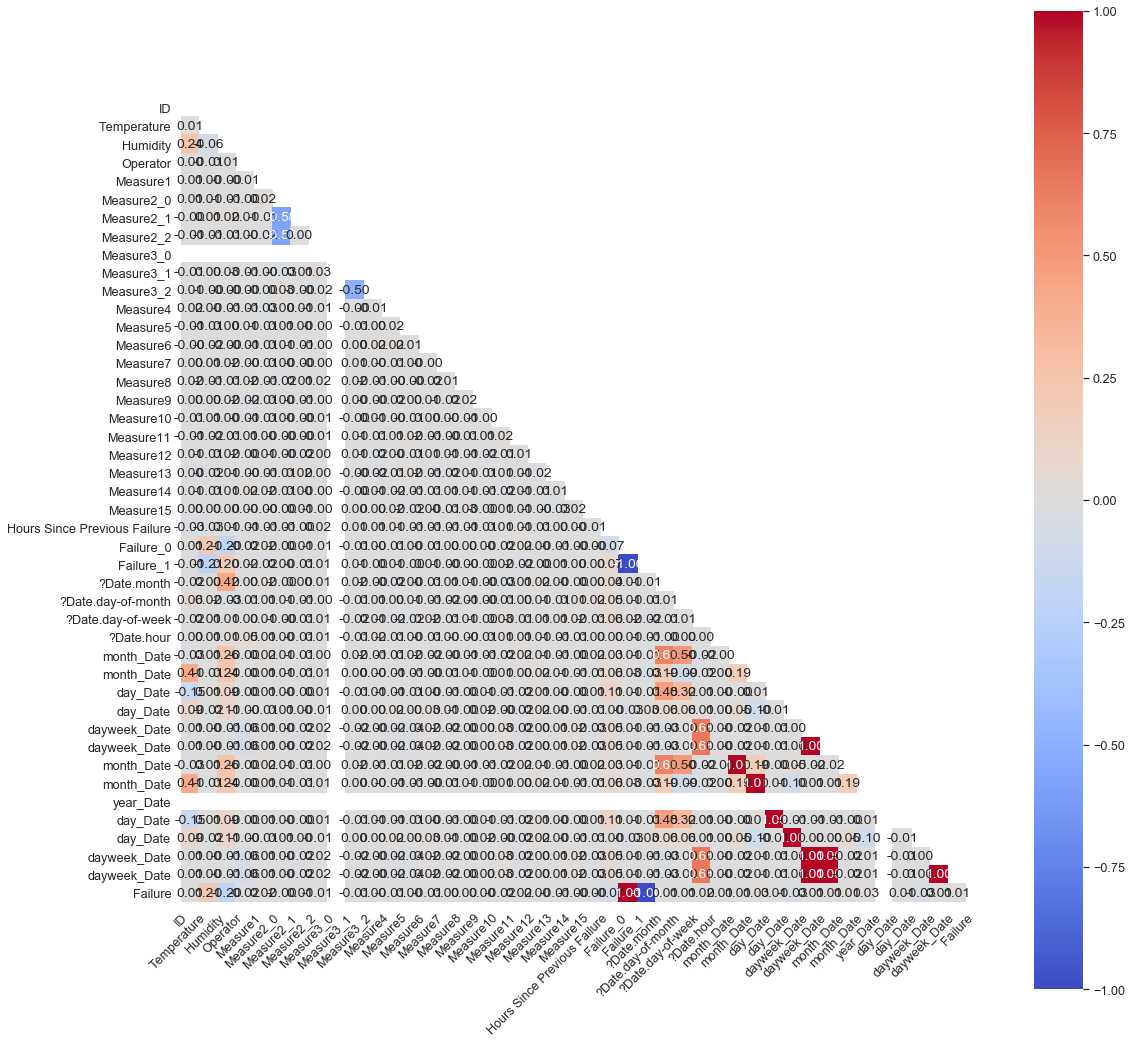

In [64]:
data1 = feature_processing(data=data, target='Failure', date_cols= ['Date'], check_outliers=False, percent = 70)

In [65]:
data1

,ID,Temperature,Humidity,Operator,Measure1,Measure2_0,Measure2_1,Measure2_2,Measure3_0,Measure3_1,...,dayweek_Date,dayweek_Date,dayweek_Date,dayweek_Date,dayweek_Date,dayweek_Date,dayweek_Date,dayweek_Date,index,Failure
0,0.000000,0.500000,0.606061,0.000000,0.617486,0.0,0.0,1.0,0.0,0.0,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0,0
1,0.140562,0.545455,0.454545,0.000000,0.095082,0.0,0.0,1.0,0.0,0.0,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,1,0
2,0.281123,0.363636,0.424242,0.000000,0.216940,0.0,0.0,1.0,0.0,0.0,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,2,0
3,0.421685,0.318182,0.545455,0.000000,0.757377,0.0,0.0,1.0,0.0,0.0,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,3,0
4,0.562247,0.409091,0.575758,0.000000,0.518579,0.0,0.0,1.0,0.0,1.0,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,0.970268,0.181818,0.575758,0.857143,0.346448,1.0,0.0,0.0,0.0,1.0,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,7900,0
7901,0.970395,0.318182,0.575758,0.857143,0.395082,1.0,0.0,0.0,0.0,1.0,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,7901,0
7902,0.970521,0.181818,0.636364,0.857143,0.273770,0.0,1.0,1.0,0.0,0.0,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,7902,0
7903,0.970648,0.318182,0.545455,0.857143,0.173770,1.0,0.0,0.0,0.0,0.0,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,7903,0


In [66]:
X = data1.drop(['index', 'Failure'], axis=1)
y = data1['Failure']

In [71]:
y_pred,y_test, model1 = RandomForestclassifier(X,y)

[10:58:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


predicted values are
[0 0 0 ... 0 0 0]
accuracy score
1.0


confusion matrix


accuracy score
1.0


precision score
1.0


recall score or true positive rate
1.0


f1 score
1.0


True Negative Rate
1.0


precision-recall trade off


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2350
           1       1.00      1.00      1.00        22

    accuracy                           1.00      2372
   macro avg       1.00      1.00      1.00      2372
weighted avg       1.00      1.00      1.00      2372



roc_auc_score
1.0


ROC curve


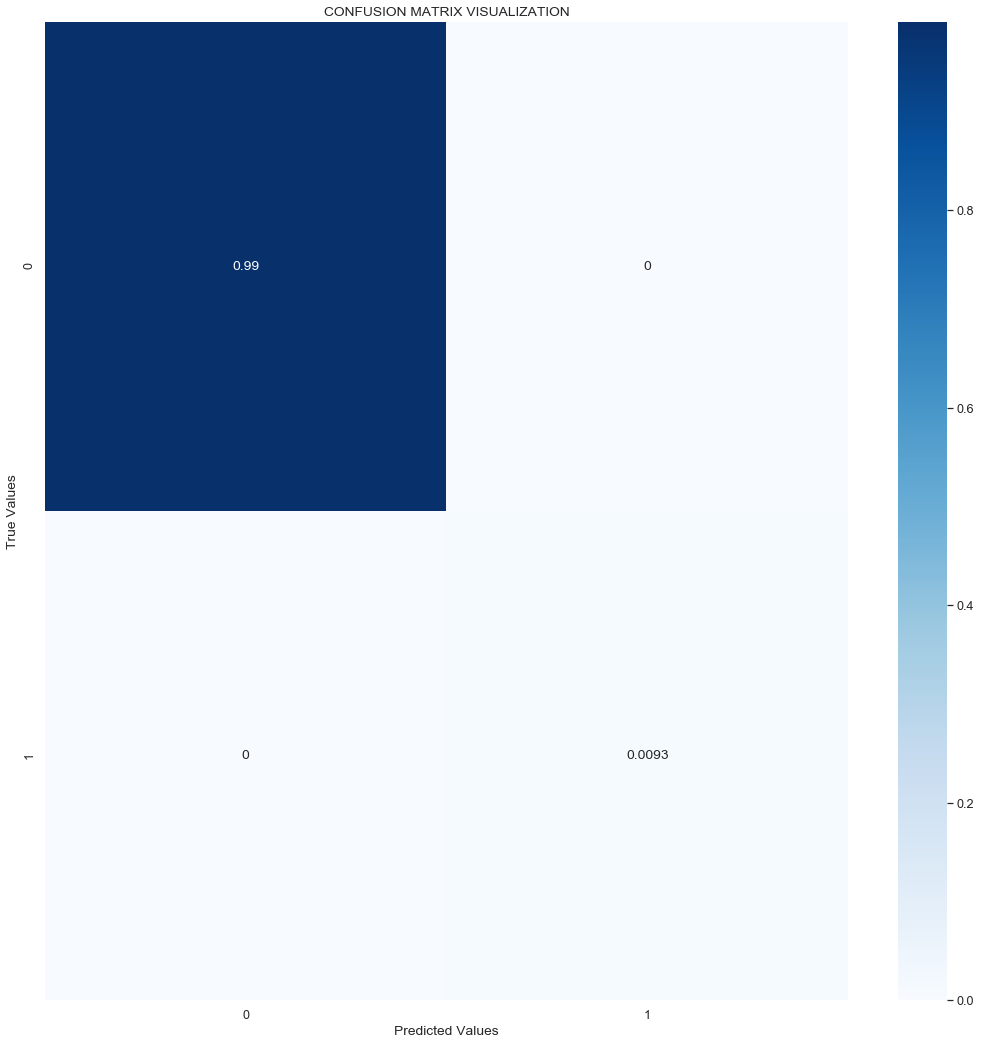

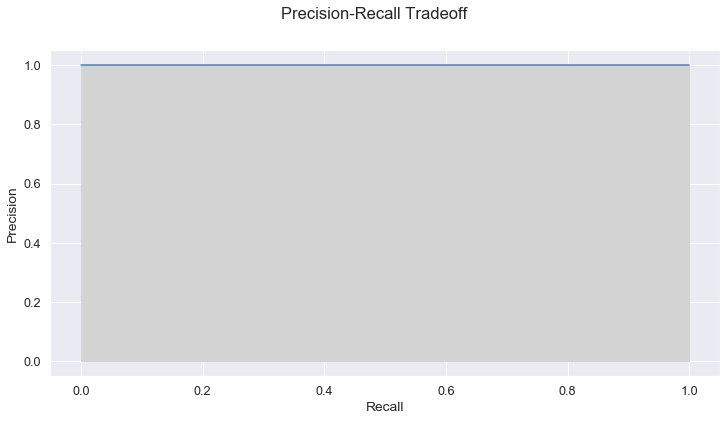

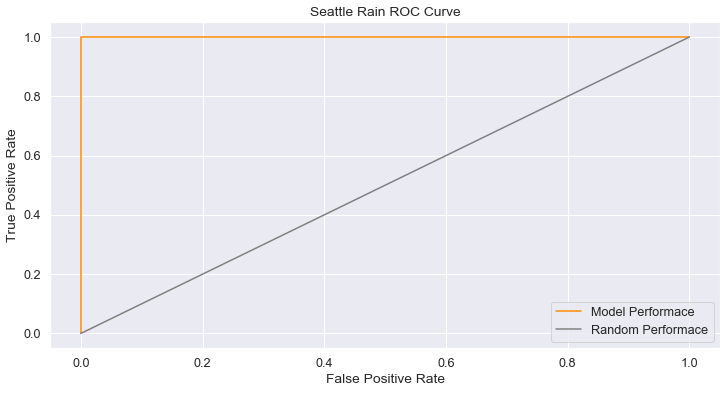

In [78]:
classification_eval(y_test, y_pred)

In [81]:
y_pred, y_test, model2 = Xgboostclassifier(X,y)

[11:01:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


predicted values are
[0 0 0 ... 0 0 0]
accuracy score
1.0


confusion matrix


accuracy score
1.0


precision score
1.0


recall score or true positive rate
1.0


f1 score
1.0


True Negative Rate
1.0


precision-recall trade off


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2350
           1       1.00      1.00      1.00        22

    accuracy                           1.00      2372
   macro avg       1.00      1.00      1.00      2372
weighted avg       1.00      1.00      1.00      2372



roc_auc_score
1.0


ROC curve


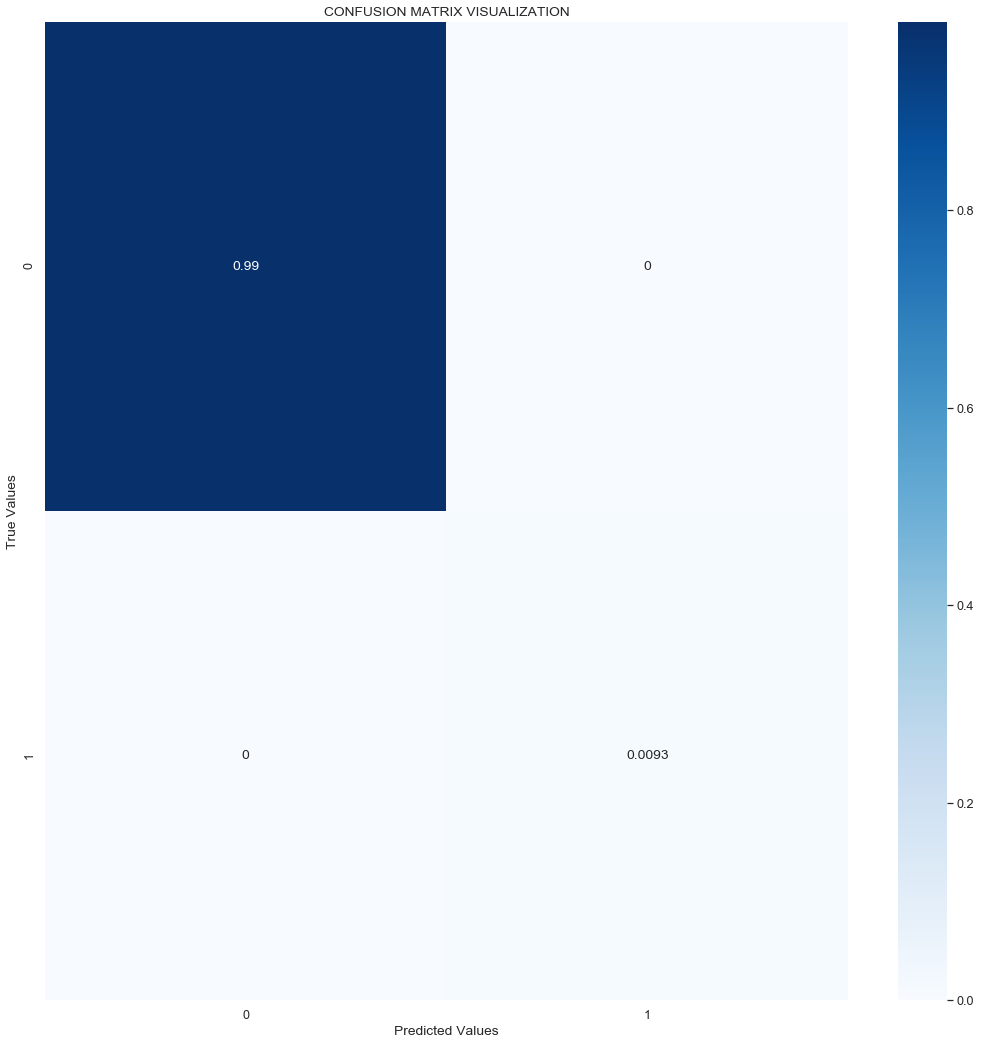

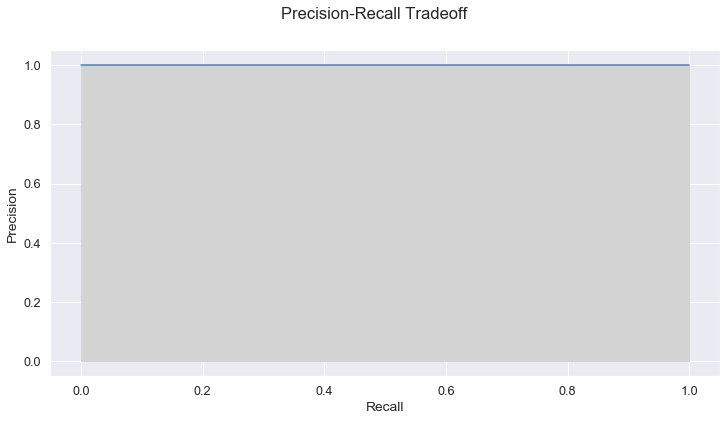

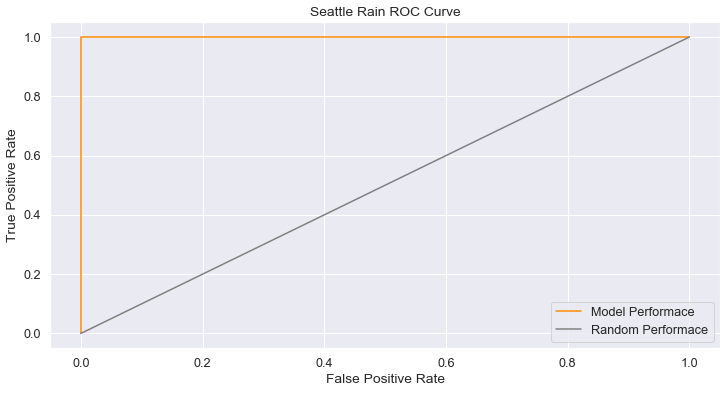

In [82]:
classification_eval(y_test, y_pred)

In [83]:
y_pred, y_test, model3 = svmClassifier(X,y)

predicted values are
[0 0 0 ... 0 0 0]
accuracy score
1.0


confusion matrix


accuracy score
1.0


precision score
1.0


recall score or true positive rate
1.0


f1 score
1.0


True Negative Rate
1.0


precision-recall trade off


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2350
           1       1.00      1.00      1.00        22

    accuracy                           1.00      2372
   macro avg       1.00      1.00      1.00      2372
weighted avg       1.00      1.00      1.00      2372



roc_auc_score
1.0


ROC curve


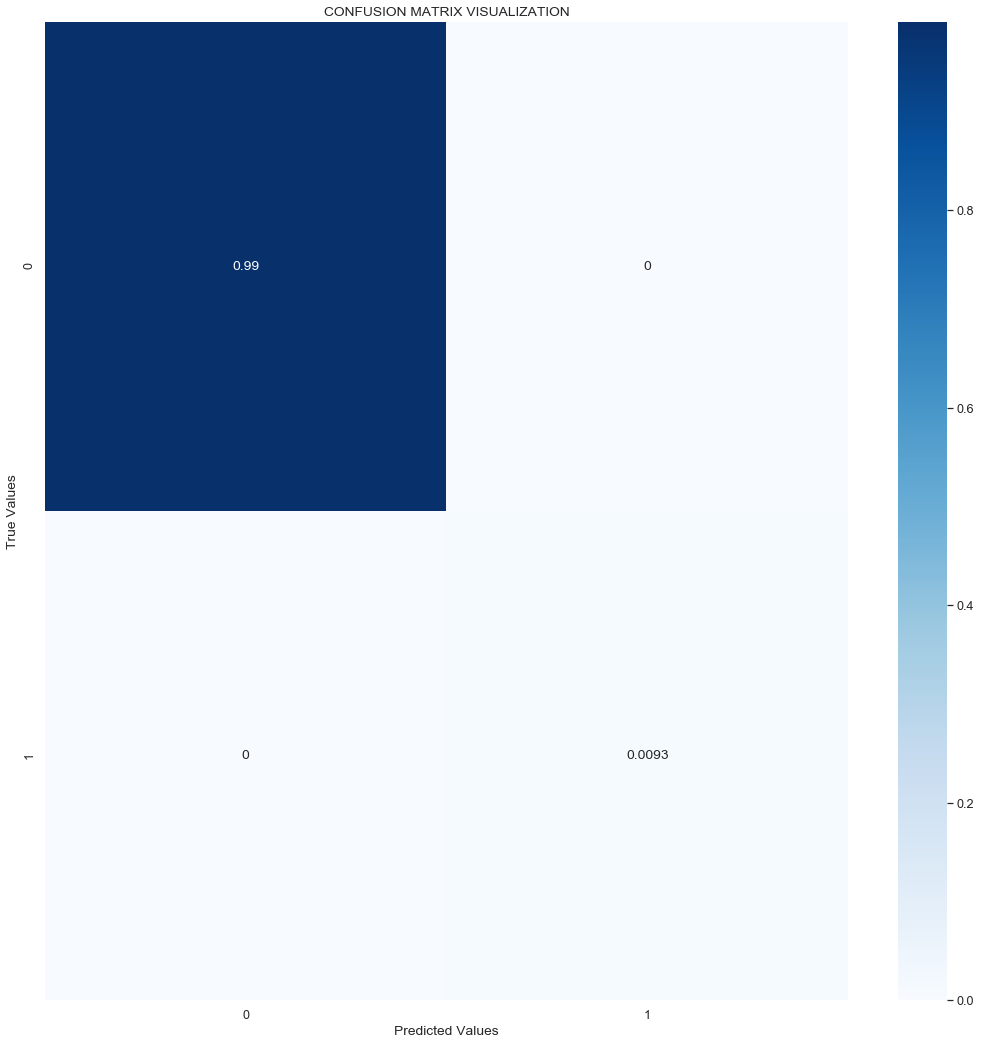

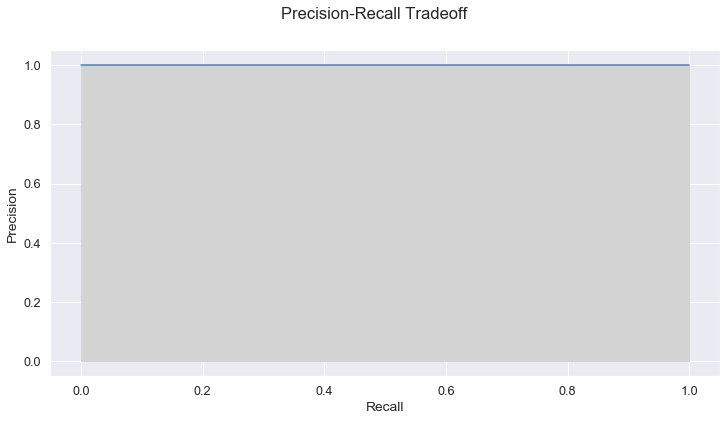

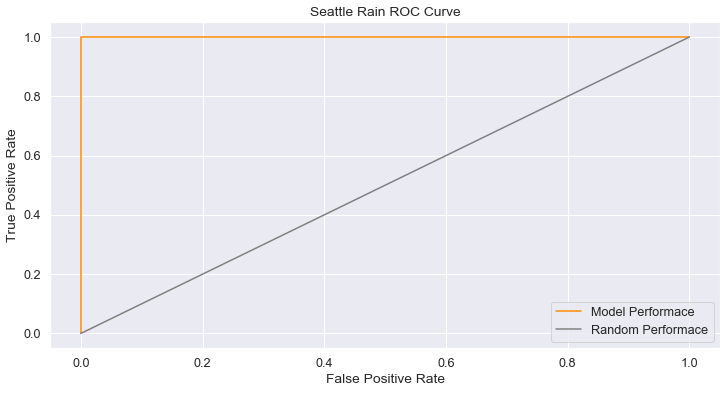

In [84]:
classification_eval(y_test, y_pred)

In [135]:
y_prob, y_test, pred, model = dnn_classifier(X,y, epochs=20)

2372/2372 [==============================] - 0s 26us/sample - loss: 0.3775 - acc: 0.9907
Test Score: 0.3774927735931757
Test Accuracy: 0.9907251
Train on 4426 samples, validate on 1107 samples
Epoch 1/20
4426/4426 [==============================] - 1s 194us/sample - loss: 0.0504 - acc: 0.9907 - val_loss: 0.0290 - val_acc: 0.9892
Epoch 2/20
4426/4426 [==============================] - 1s 151us/sample - loss: 0.0122 - acc: 0.9953 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 3/20
4426/4426 [==============================] - 1s 162us/sample - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 4/20
4426/4426 [==============================] - 1s 189us/sample - loss: 5.8524e-04 - acc: 1.0000 - val_loss: 4.2398e-04 - val_acc: 1.0000
Epoch 5/20
4426/4426 [==============================] - 1s 166us/sample - loss: 2.3967e-04 - acc: 1.0000 - val_loss: 1.8357e-04 - val_acc: 1.0000
Epoch 6/20
4426/4426 [==============================] - 1s 162us/sample - loss: 9.6159e-05 - acc: 1.0

confusion matrix


accuracy score
0.9907251264755481


precision score
0.0


recall score or true positive rate
0.0


f1 score
0.0


True Negative Rate
1.0


precision-recall trade off


Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2350
           1       0.00      0.00      0.00        22

    accuracy                           0.99      2372
   macro avg       0.50      0.50      0.50      2372
weighted avg       0.98      0.99      0.99      2372



roc_auc_score
0.5


ROC curve


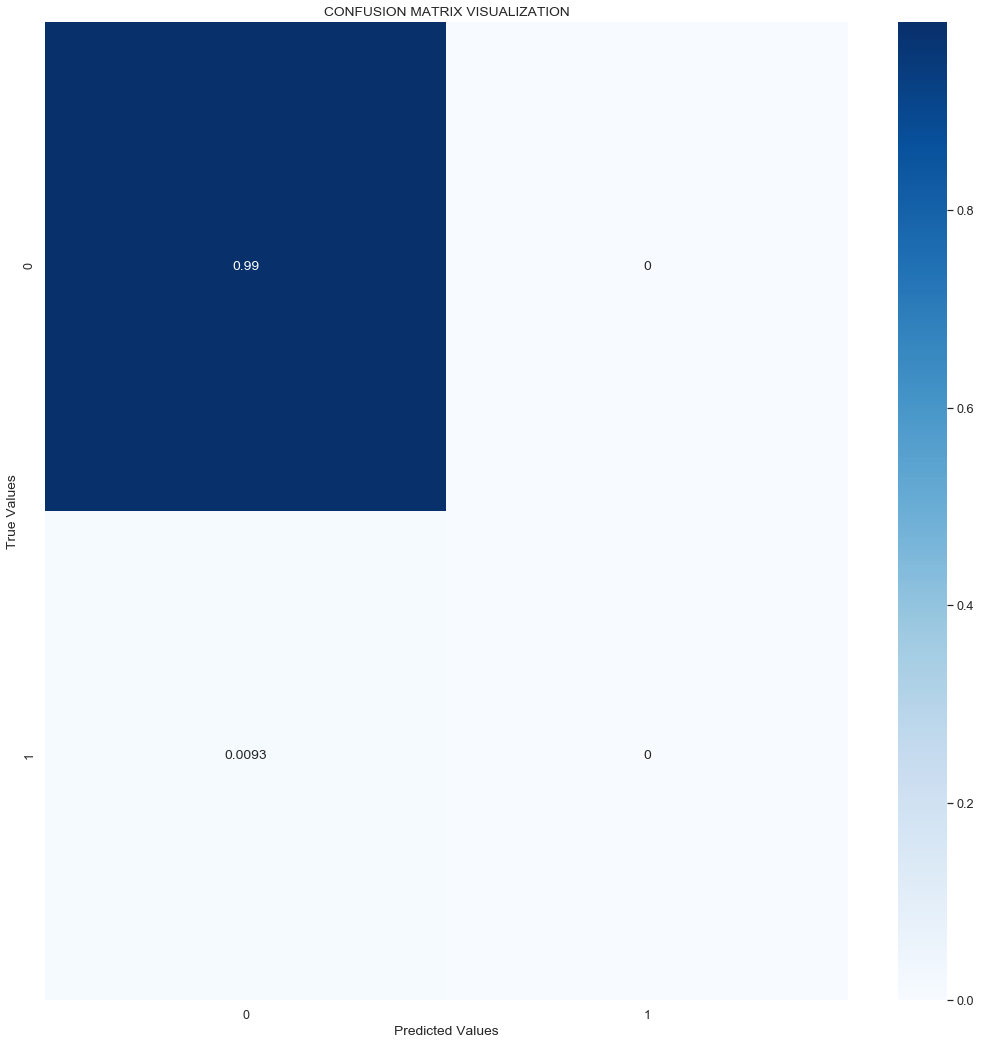

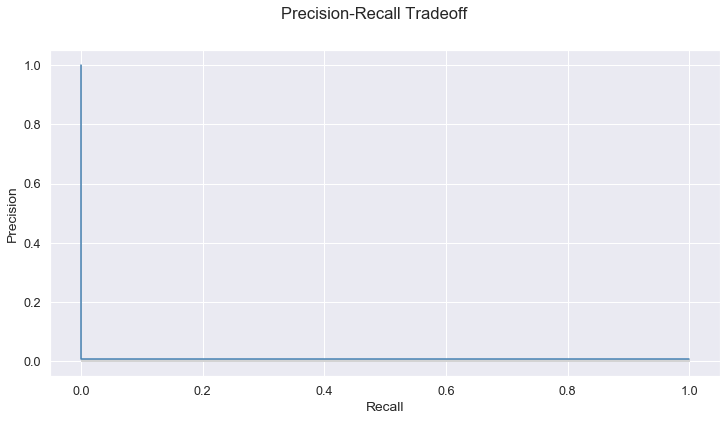

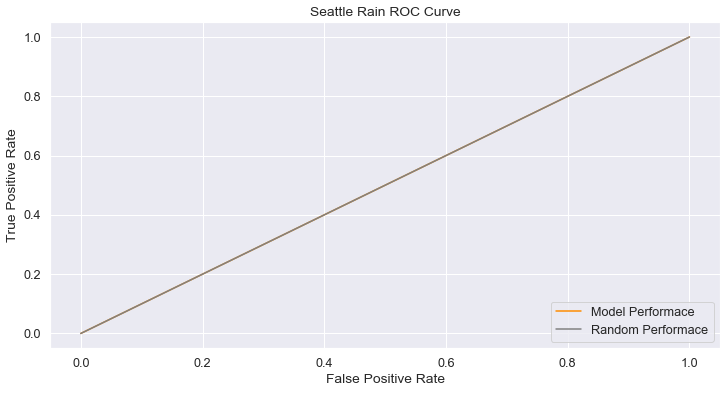

In [136]:
classification_eval(y_test, pred)

In [ ]:
combined_ftest(X, y, estimator1 = model1, estimator2 = model2)

In [ ]:
combined_ftest(X, y, estimator1 = model2, estimator2 = model3)

In [ ]:
combined_ftest(X, y, estimator1 = model1, estimator2 = model3)

In [ ]:
paired_ttest(X, y, estimator1 = model1, estimator2 = model2)

In [ ]:
paired_ttest(X, y, estimator1 = model2, estimator2 = model3)

In [ ]:
paired_ttest(X, y, estimator1 = model1, estimator2 = model3)

### Notes.

1. Added  functions for scaling, normalising and removing outliers  dataset. Then a master function 'scale_normalize_data' that use standard_scaler for normalization as default. It can also use robust_scaler when method is set to 'normalize_outlier'. It also uses minmax_scalere for scaling when method is set to'scale'. 
2. Made change to the feature_processing function to only output numeric columns as part of the dataframe. 
3. The 3 master functions are **describe** and **feature_processing**  functions.
4. The hashing of the ids is done by the **feature_processing** function.
5. Added a part for ml modelling, evaluation and significance of two ml model performance difference

## ######################## THE END ########################## ##